In [1]:
import pandas as pd
import numpy as np
# Sets and Parameters 1
scale = 1
n = 100
m = 12
r = 3
set_I = range(1,n+1)
set_K = range(1,m+1)
set_T = range(1,r+1)
c = {k: 4 for k in set_K}
delta = {k: 3 for k in set_K}
gamma = {k: 2 for k in set_K}
e = {k: 0.1 for k in set_K}
P_it = [];alpha_i = [];CS_coor=[];Users_coor=[]
# lambda_ikt = pd.read_table("./lambda.csv",sep=",")
# P_it = pd.read_table("./P.csv",sep=",")
# alpha_i = pd.read_table("./alpha.csv",sep=",")
# CS_coor = pd.read_table("./CS candidates coordinates.csv",sep=",")
# Users_coor = pd.read_table("./Users coordinates.csv",sep=",")
def import_data(n,m):
    global P_it,alpha_i,CS_coor,Users_coor
    P_it = pd.read_table("./Data/P_{0}_{1}.csv".format(n,m),sep=",")
    alpha_i = pd.read_table("./Data/alpha_{0}_{1}.csv".format(n,m),sep=",")
    CS_coor = pd.read_table("./Data/CS candidates coordinates_{0}_{1}.csv".format(n,m),sep=",")
    Users_coor = pd.read_table("./Data/Users coordinates_{0}_{1}.csv".format(n,m),sep=",")
import_data(n,m)
P = {(i,t): P_it.iloc[i-1][t-1] for i in set_I for t in set_T} 
# lambda_ = {(j%n+1,k,j//n+1): lambda_ikt.iloc[j][k-1] for j in range(n*r) for k in set_K}
alpha = alpha_i.values.flatten()
cord_x = np.zeros([r,n])                    
cord_y = np.zeros([r,n])
for i in range(n):
    for j in range(r):
        cord_x[j][i] = np.array(Users_coor.iloc[i][2*j])
        cord_y[j][i] = np.array(Users_coor.iloc[i][2*j+1])
cord_x_K = np.array(CS_coor["x"])
cord_y_K = np.array(CS_coor["y"])
max_beta = len(c)*(list(c.values())[0]*list(delta.values())[0]) # maximum budget

<Figure size 432x288 with 0 Axes>

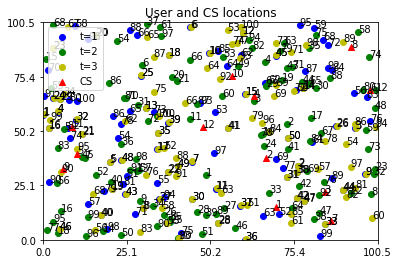

In [2]:
import os
import matplotlib.pyplot as plt
plt.figure()
fig,ax=plt.subplots()
plt.xlim(xmin = 0, xmax = (scale*n)+0.5)                  
plt.ylim(ymin = 0, ymax = (scale*n)+0.5)                  
plt.xticks(np.linspace(0, (scale*n)+0.5, 5))
plt.yticks(np.linspace(0, (scale*n)+0.5, 5))
# plt.grid()
plt.title('User and CS locations')
color_lst = ['b','g','y','m','c']
label_lst = ['t=1','t=2','t=3','t=4','t=5']
for t in range(r):
    plt.scatter(cord_x[t], cord_y[t], marker = 'o', color=color_lst[t], label=label_lst[t])
    for i,txt in enumerate(np.arange(1,n+1)):
        ax.annotate(txt,(cord_x[t][i],cord_y[t][i]))
plt.scatter(cord_x_K, cord_y_K, marker = '^', color='r', label='CS')
for i,txt in enumerate(np.arange(1,m+1)):
    ax.annotate(txt,(cord_x_K[i],cord_y_K[i]))
plt.legend()
path = os.getcwd()              
fileName = "User and CS locations"
filePath = path + "\\" + fileName + ".png"
plt.savefig(filePath, dpi=1500,facecolor='w')  

In [3]:
# Sets and Parameters 2 : lambda
# Euclidean distance between users and stations
dist = np.zeros([r,m,n])
for t in range(r):
    for k in range(m):
        for i in range(n):
            dist[t][k][i] = np.array(np.sqrt((cord_x[t][i]-cord_x_K[k])**2 + (cord_y[t][i]-cord_y_K[k])**2))
# Normalization
normal_dist = np.zeros([r,m,n])
lambda_ = {}
for t in range(r):
    for k in range(m):
        for i in range(n):
#             normal_dist[t][k][i] = (dist[t][k][i]-min(dist[t][k]))/(max(dist[t][k])-min(dist[t][k]))
            normal_dist[t][k][i] = dist[t][k][i]/dist.max()
            lambda_[(i+1,k+1,t+1)] = round(normal_dist[t][k][i],2)
# number of zones (here set 0-1)

In [4]:
# Sets and Parameters 3 : v -- the preference list assume length s = 2 
from heapq import nsmallest
s = 3
set_S = range(1,s+1)
comb_dict = {}
comb = {}
v = {}
for i in range(n+1):
    comb_dict[i-1]=nsmallest(s, comb, key = comb.get) # select first s smallest elements in combination
    comb = {}
    if i==n:
        break
    for k in set_K:
        for t in set_T:
            comb[(k,t)] = alpha[i]*lambda_[(i+1,k,t)]+(1-alpha[i])*P[(i+1,t)]/max(P.values())
del comb_dict[-1]      # preference lists
for t in set_T:
    for k in set_K:
        for i in range(n):
            for l in range(s):
                v[(i+1,l+1,k,t)] = 1 if (k,t) == comb_dict[i][l] else 0 

In [5]:
import docplex.mp.model as cpx
import math
opt_model = cpx.Model(name="HPR")
M_0 = 100 # M_0 >> max(P)
eplison = 1e-5
M51 = 1 * (sum(lambda_.values()) + sum(l * v[i, l, k, t] for i in set_I for k in set_K for t in set_T for l in set_S)) / (m*r) + 0
M52 = 1 * (sum(lambda_.values()) + sum(l * v[i, l, k, t] for i in set_I for k in set_K for t in set_T for l in set_S)) / (m*r) + 0
M61 = 1 * (sum(lambda_.values()) + sum(l * v[i, l, k, t] for i in set_I for k in set_K for t in set_T for l in set_S)) / (m*r) + 0
M62 = 1 * (sum(lambda_.values()) + sum(l * v[i, l, k, t] for i in set_I for k in set_K for t in set_T for l in set_S)) / (m*r) + 0


# define dictionary set J_k
J = {}
for k in set_K:
    J[k] = np.arange(delta[k])+1

# if x is Continuous
p  = {(k,t): opt_model.continuous_var(ub=M_0,name="p_{0}_{1}".format(k,t)) for k in set_K for t in set_T}

# upper bound for p is set to M0

# if x is Binary
x  = {(i,k,t): opt_model.binary_var(name="x_{0}_{1}_{2}".format(i,k,t)) for i in set_I for k in set_K for t in set_T}

w  = {(i,l,k,t): opt_model.binary_var(name="w_{0}_{1}_{2}_{3}".format(i,l,k,t)) for i in set_I for l in set_S for k in set_K for t in set_T}

z = {(i): opt_model.binary_var(name="z_{0}".format(i)) for i in set_I}

u = {}
for k in set_K:
    for j in J[k]:
        u[k,j] = opt_model.binary_var(name="u_{0}_{1}".format(k,j))

# define objective
objective = opt_model.sum(p[k,t]*x[i,k,t] for i in set_I for k in set_K for t in set_T) - opt_model.sum(c[k]*u[k,j] for k in set_K for j in J[k]) - opt_model.sum(e[k]*x[i,k,t] for i in set_I for k in set_K for t in set_T)      

# Updating predefining preference list based on cost

constraint_11 = {(i,t,k,l) : opt_model.add_constraint(ct= v[i,l,k,t]*eplison + (v[i,l,k,t]*(P[i,t]-p[k,t]))/M_0 <= w[i,l,k,t],ctname="constraint11_{0}_{1}_{2}_{3}".format(i,t,k,l))
    for i in set_I for t in set_T for k in set_K for l in set_S}

constraint_12 = {(i,t,k,l) : opt_model.add_constraint(ct= v[i,l,k,t] + (v[i,l,k,t]*(P[i,t]-p[k,t]))/M_0 >= w[i,l,k,t],ctname="constraint12_{0}_{1}_{2}_{3}".format(i,t,k,l))
    for i in set_I for t in set_T for k in set_K for l in set_S}

# Reinforcing opt-in / out

constraint_21 = {(i) : opt_model.add_constraint(ct= opt_model.sum(w[i,l,k,t] for k in set_K for l in set_S for t in set_T)/s <= z[i],ctname="constraint21_{0}".format(i))
    for i in set_I}

constraint_22 = {(i) : opt_model.add_constraint(ct= opt_model.sum(w[i,l,k,t] for k in set_K for l in set_S for t in set_T) >= z[i],ctname="constraint22_{0}".format(i))
    for i in set_I}

# capacity 9(b)
constraint_3 = {(k): opt_model.add_constraint(ct= opt_model.sum( u[k, j] for j in J[k])-delta[k] <= 0, ctname="constraint_3_{0}".format(k)) for k in set_K}
   
# budget 9(c)
constraint_4 = opt_model.add_constraint(ct=opt_model.sum(c[k] * u[k, j] for k in set_K for j in J[k]) - 0.5*max_beta <= 0, ctname="constraint_4")

# usage limitation
constraint_5 = {(k,t) : opt_model.add_constraint(ct= opt_model.sum(x[i,k,t] for i in set_I)-gamma[k]*opt_model.sum(u[k,j] for j in J[k]) <= 0, ctname="constraint5_{0}_{1}".format(k,t))
    for t in set_T for k in set_K}

# Ensure EV users to select at most only the CS from their preference list
constraint_61 = {(i) : opt_model.add_constraint(ct= opt_model.sum(x[i,k,t] for k in set_K for t in set_T) - z[i] == 0 ,ctname="constraint_61_{0}".format(i))
    for i in set_I}

constraint_62 = {(i,t,k) : opt_model.add_constraint(ct= x[i,k,t] - opt_model.sum(w[i,l,k,t] for l in set_S) <= 0,ctname="constraint_62_{0}_{1}_{2}".format(i,t,k))
    for i in set_I for t in set_T for k in set_K}

In [6]:
print(M51,M52)

58.73527777777773 58.73527777777773


In [7]:
opt_model.maximize(objective)
sol = opt_model.solve()
w1 = sol.get_value_dict(w)
x1 = sol.get_value_dict(x)
z1 = sol.get_value_dict(z)
p1 = sol.get_value_dict(p)
u1 = sol.get_value_dict(u)

In [8]:
sol.get_objective_value()

271.0000000000002

In [9]:
opt_model.solve_details.time

15.422000000020489

In [10]:
print(len(w1),len(x1),len(z1),len(p1),len(u1)) #some variable may be missing

10800 3600 100 36 36


In [11]:
for i in set_I:
    for l in set_S:
        for k in set_K:
            for t in set_T:
                for j in J[k]:
                    try:
                        w1[i,l,k,t]
                    except KeyError:
                        w1[i,l,k,t]=0
                    try:
                        x1[i,k,t]
                    except KeyError:
                        x1[i,k,t]=0
                    try:
                        z1[i]
                    except KeyError:
                        z1[i]=0
                    try:
                        u1[k,j]
                    except KeyError:
                        u1[k,j]=0        

In [12]:
print(len(w1),len(x1),len(z1),len(p1),len(u1))

10800 3600 100 36 36


In [ ]:
# loop of cutting plane method algorithm
opt = False
iter_ = 0
niter = 300
cut = {}
sol_time = 0
w1_last_iter = w1
u1_last_iter = u1
x1_last_iter = x1
sol_follower_list = np.zeros(niter) #the gap at each iteration
while opt == False and iter_ < niter:
    iter_ += 1
    print("The current iteration is: %d" %iter_)
    
    opt_model.maximize(objective)
#     opt_model.print_information()
    sol = opt_model.solve(log_output=False)
    sol_time += opt_model.solve_details.time
    var = {"x": x, "u": u, "z": z, "p": p, "w": w}
    optimal_objective = sol.get_objective_value()
    # print(sol.get_objective_value())
    # prob.print_solution()
    
    # x prime
    x1 = sol.get_value_dict(var["x"])
    
    # y1 = sol.get_value_dict(var["y"])
    # p1 = sol.get_value_dict(var["p"])
    z1 = sol.get_value_dict(var["z"])
    w1 = sol.get_value_dict(var["w"])
    u1 = sol.get_value_dict(var["u"])
    
    #fix the "-0.0 key error"
    for i in set_I:
        for l in set_S:
            for k in set_K:
                for t in set_T:
                    for j in J[k]:
                        try:
                            w1[i,l,k,t]
                        except KeyError:
                            w1[i,l,k,t]=0
                        try:
                            x1[i,k,t]
                        except KeyError:
                            x1[i,k,t]=0
                        try:
                            z1[i]
                        except KeyError:
                            z1[i]=0
                        try:
                            u1[k,j]
                        except KeyError:
                            u1[k,j]=0            
    
    
    print("the following variables changed because of the cut:")
    # Detect the changed w'
    [print("w_{0}_{1}_{2}_{3} = %d".format(i, l, k, t) % w1[i, l, k, t]) for i in set_I for l in set_S for k in set_K for t in set_T if abs(w1[i, l, k, t]-w1_last_iter[i, l, k, t]) > 0.01]
    
    print("\n")
    # Detect the changed u'
    [print("u_{0}_{1} = %d".format(k, j) % u1[k, j]) for k in set_K for j in J[k] if abs(u1_last_iter[k,j]-u1[k, j]) >=0.01]
    
    print("\n")
    # Detect the changed x'
    [print("x_{0}_{1}_{2} = %d".format(i, k, t) % x1[i, k, t]) for i in set_I for k in set_K for t in set_T if abs(x1[i, k, t]-x1_last_iter[i, k, t]) > 0.01]
    
    # Define the separation problem
    prob2 = cpx.Model(name="EV Model2")  # model name

    # Variables
    X = {(i, k, t): prob2.binary_var(name="X_{0}_{1}_{2}".format(i, k, t)) for i in set_I for k in set_K for t in set_T}

    # objective function of the follower
    objective2 = prob2.sum(
        (lambda_[i, k, t] + prob2.sum(float(l) * w1[i, l, k, t] for l in set_S)) * X[i, k, t] for i in set_I for k in
        set_K for t in set_T)

    # constraints: They are named according to (5) in report2.pdf

    con1m = {(k, t): prob2.add_constraint(
        ct=prob2.sum(X[i, k, t] for i in set_I) - gamma[k] * prob2.sum(u1[k, j] for j in J[k]) <= 0,
        ctname="con1m_{0}_{1}".format(k, t))
        for k in set_K for t in set_T}
    # [print("%s" % str(con1m[k, t])) for k in K for t in T]

    con1n = {i: prob2.add_constraint(ct=prob2.sum(X[i, k, t] for k in set_K for t in set_T) - z1[i] == 0,
                                     ctname="con1n_{0}".format(i))
             for i in set_I}
    # [print("%s" % str(con1n[i])) for i in I]

    con1o = {(i, k, t): prob2.add_constraint(ct=X[i, k, t] <= prob2.sum(w1[i, l, k, t] for l in set_S),
                                             ctname="con1o_{0}_{1}_{2}".format(i, k, t))
             for i in set_I for k in set_K for t in set_T}
    # [print("%s" % str(con1o[i, k, t])) for i in I for k in K for t in T]

    prob2.minimize(objective2)
    # prob2.print_information()

    # prob2.parameters.mip.tolerances.mipgap = 0.001
    # prob.parameters.timelimit = 500
    solf = prob2.solve(log_output=False)
    sol_time += prob2.solve_details.time
    var = {"x": X}
    
    # x star
    X1 = solf.get_value_dict(var["x"])
    
    #fix the "-0.0 key error"
    for i in set_I:
        for k in set_K:
            for t in set_T:
                try:
                    X1[i,k,t]
                except KeyError:
                    X1[i,k,t]=0
                        
    # two optimal objective value
    sol1 = sum(
        (lambda_[i, k, t] + sum(float(l) * w1[i, l, k, t] for l in set_S)) * x1[i, k, t] for i in set_I for k in set_K for
        t in set_T)
    sol2 = sum(
        (lambda_[i, k, t] + sum(float(l) * w1[i, l, k, t] for l in set_S)) * X1[i, k, t] for i in set_I for k in set_K for
        t in set_T)
    
    nbr1 = sum(x1[i, k, t] * w1[i, l, k, t] for i in set_I for k in set_K for t in set_T)
    nbr2 = sum(X1[i, k, t] * w1[i, l, k, t] for i in set_I for k in set_K for t in set_T)
    
    print("HPR_optimal_objective = " + str(optimal_objective) + ", lower_x\'_sol1 = " + str(sol1) + ", lower_x^*_sol2 = " + str(sol2))
    
    print("sol_time: ",sol_time)
    
    # track the gap
    
    sol_follower_list[iter_-1] = sol1-sol2
    
    if abs(sol1 - sol2) <= 0.1:
        print("the obtained solution is optimal")
        optimal = True
        print("optimal= ", optimal)
        break
    else:
        print("the obtained solution is infeasible, a new cut will be added into next iteration's HPR")
    print("\n *******************************************************************\n")
        
    cut[iter_] = opt_model.add_constraint(ct=opt_model.sum((lambda_[i, k, t] + opt_model.sum(float(l) * v[i, l, k, t] for l in set_S)) *
                           x[i, k, t] for i in set_I for k in set_K for t in set_T) <= sum((lambda_[i, k, t] +
                           sum(float(l) * w1[i, l, k, t] for l in set_S)) * X1[i, k, t] for i in set_I for k in set_K for
                           t in set_T) + (sum(u1[k, j] for k in set_K for j in J[k]) - opt_model.sum( u1[k, j] * u[k, j] for
                           k in set_K for j in J[k])) * 1*M51 + (opt_model.sum(w1[i, l, k, t] for i in set_I for k in set_K for t in
                           set_T for l in set_S) - opt_model.sum(w1[i, l, k, t] * w[i, l, k, t] for i in set_I for k in set_K for t
                           in set_T for l in set_S)) * 1*M52+(opt_model.sum(u[k, j] for k in set_K for j in J[k]) - opt_model.sum( u1[k, j] * u[k, j] for
                           k in set_K for j in J[k])) *1* M61 + (opt_model.sum(w[i, l, k, t] for i in set_I for k in set_K for t in
                           set_T for l in set_S) - opt_model.sum(w1[i, l, k, t] * w[i, l, k, t] for i in set_I for k in set_K for t
                           in set_T for l in set_S)) *1* M62, ctname="cut_iter_{0}".format(iter_))


        # optimal = False
        #print("optimal = " + str(optimal))
    
    # clear variables and constraints
    w1_last_iter = w1
    u1_last_iter = u1
    x1_last_iter = x1
    del (X1)
    prob2.clear_constraints()
    prob2.clear()
    

The current iteration is: 1
the following variables changed because of the cut:




HPR_optimal_objective = 270.9999999999989, lower_x'_sol1 = 206.51999999999998, lower_x^*_sol2 = 199.30999999999997
sol_time:  17.593999999808148
the obtained solution is infeasible, a new cut will be added into next iteration's HPR

 *******************************************************************

The current iteration is: 2
the following variables changed because of the cut:
w_8_2_7_2 = 0
w_22_2_7_2 = 0
w_23_2_7_2 = 0
w_42_3_3_3 = 0
w_51_3_3_3 = 0
w_54_1_3_3 = 0
w_61_3_3_3 = 0
w_81_1_3_3 = 0
w_82_2_3_3 = 0
w_85_3_3_3 = 0
w_97_1_3_3 = 0




x_10_10_1 = 0
x_10_12_1 = 0
x_11_1_3 = 1
x_11_2_3 = 0
x_15_10_1 = 0
x_15_12_1 = 0
x_23_3_2 = 0
x_23_7_2 = 0
x_42_1_3 = 0
x_42_3_2 = 1
x_47_3_3 = 1
x_47_7_2 = 0
x_49_2_1 = 1
x_49_12_1 = 0
x_54_2_3 = 0
x_54_3_3 = 0
x_97_2_1 = 0
x_97_12_1 = 1
HPR_optimal_objective = 271.000000855597, lower_x'_sol1 = 212.72999683385942, lower_x^*_sol2 = 214.91999999165887
sol_time:  

In [ ]:
sol_follower_list

In [44]:
sol_time

7.343000000575557

In [45]:
# export and analyse
import pandas as pd
df_x = pd.DataFrame.from_dict(x, orient="index", 
                                columns = ["variable_object"])
df_x.index = pd.MultiIndex.from_tuples(df_x.index, 
                               names=["i", "k", "t"])
df_x.reset_index(inplace=True)

df_x["solution_value"] = df_x["variable_object"].apply(lambda item: item.solution_value)
    
df_x.drop(columns=["variable_object"], inplace=True)
df_x.to_csv("./opt_x_for_cpm.csv")

In [46]:
df_p = pd.DataFrame.from_dict(p, orient="index", 
                                columns = ["variable_object"])
df_p.index = pd.MultiIndex.from_tuples(df_p.index, 
                               names=["k", "t"])
df_p.reset_index(inplace=True)

# CPLEX
df_p["solution_value"] = df_p["variable_object"].apply(lambda item: item.solution_value)
    
df_p.drop(columns=["variable_object"], inplace=True)
df_p.to_csv("./opt_p_for_cpm.csv")

In [47]:
df_u = pd.DataFrame.from_dict(u, orient="index", 
                                columns = ["variable_object"])
df_u.index = pd.MultiIndex.from_tuples(df_u.index, 
                               names=["k","j"])
df_u.reset_index(inplace=True)

# CPLEX
df_u["solution_value"] = df_u["variable_object"].apply(lambda item: item.solution_value)
    
df_u.drop(columns=["variable_object"], inplace=True)
df_u.to_csv("./opt_u_for_cpm.csv")

In [48]:
df_z = pd.DataFrame.from_dict(z, orient="index", 
                                columns = ["variable_object"])
df_z.index = pd.Index(df_z.index,name="i")
df_z.reset_index(inplace=True)

# CPLEX
df_z["solution_value"] = df_z["variable_object"].apply(lambda item: item.solution_value)
    
df_z.drop(columns=["variable_object"], inplace=True)
df_z.to_csv("./opt_z_for_cpm.csv")

In [49]:
df_w = pd.DataFrame.from_dict(w, orient="index", 
                                columns = ["variable_object"])
df_w.index = pd.MultiIndex.from_tuples(df_w.index, 
                               names=["i", "l", "k", "t"])
df_w.reset_index(inplace=True)

# CPLEX
df_w["solution_value"] = df_w["variable_object"].apply(lambda item: item.solution_value)
    
df_w.drop(columns=["variable_object"], inplace=True)
df_w.to_csv("./opt_w_for_cpm.csv")

In [50]:
# Active EV Users 
sum(df_z['solution_value'])

40.0

In [52]:
# Active CS
len(np.where(df_u['solution_value']!=0)[0])

7

In [53]:
# active EV users who got 1st 2nd choices
loc_res = df_x.loc[abs(df_x['solution_value']-1)<=0.01 ,['i','k','t']]
pre_choice = df_w.loc[abs(df_w['solution_value']-1)<=0.01,['i','l','k','t']]
correct_res = pd.merge(loc_res, pre_choice, how='inner', on=['i','k','t'])
first = np.array(correct_res.loc[correct_res['l']==1]['i'])
second = np.array(correct_res.loc[correct_res['l']==2]['i'])
third = np.array(correct_res.loc[correct_res['l']==3]['i'])
print(len(first),len(second),len(third))

13 13 14


<Figure size 432x288 with 0 Axes>

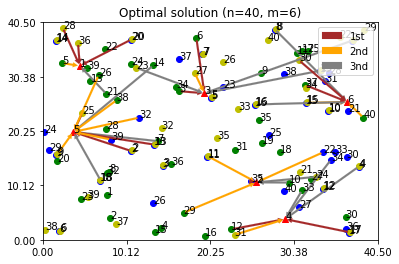

In [54]:
plt.figure()
fig,ax=plt.subplots()
plt.xlim(xmin = 0, xmax = (scale*n)+0.5)                  
plt.ylim(ymin = 0, ymax = (scale*n)+0.5)                  
plt.xticks(np.linspace(0, (scale*n)+0.5, 5))
plt.yticks(np.linspace(0, (scale*n)+0.5, 5))
# plt.grid()
plt.title('Optimal solution (n=40, m=6)')
color_lst_arrow = ['brown','orange','grey']
label_lst_arrow = ['1st','2nd','3nd']
for i in set_I:
    for k in set_K:
        for t in set_T:
            if i in first and v[i,1,k,t] == 1:
                h1=ax.annotate(text="",xy=(cord_x_K[k-1],cord_y_K[k-1]),xytext=(cord_x[t-1][i-1],cord_y[t-1][i-1]),arrowprops=dict(arrowstyle="simple",color=color_lst_arrow[0],linewidth=0.1),label=label_lst_arrow[0])
            if i in second and v[i,2,k,t] == 1:
                h2=ax.annotate(text="",xy=(cord_x_K[k-1],cord_y_K[k-1]),xytext=(cord_x[t-1][i-1],cord_y[t-1][i-1]),arrowprops=dict(arrowstyle="simple",color=color_lst_arrow[1],linewidth=0.1),label=label_lst_arrow[1])
            if i in third and v[i,3,k,t] == 1:
                h3=ax.annotate(text="",xy=(cord_x_K[k-1],cord_y_K[k-1]),xytext=(cord_x[t-1][i-1],cord_y[t-1][i-1]),arrowprops=dict(arrowstyle="simple",color=color_lst_arrow[2],linewidth=0.1),label=label_lst_arrow[2])

color_lst = ['b','g','y','m','c']
label_lst = ['user_t=1','user_t=2','user_t=3','user_t=4','user_t=5']
for t in range(r):
    ax.scatter(cord_x[t], cord_y[t], marker = 'o', color=color_lst[t])
    for i,txt in enumerate(np.arange(1,n+1)):
        ax.annotate(txt,(cord_x[t][i],cord_y[t][i]))
ax.scatter(cord_x_K, cord_y_K, marker = '^', color='r')
for i,txt in enumerate(np.arange(1,m+1)):
    ax.annotate(txt,(cord_x_K[i],cord_y_K[i]))

ax.legend([h1.arrow_patch,h2.arrow_patch,h3.arrow_patch],tuple(label_lst_arrow),loc='upper right')
# path = os.getcwd()              
# fileName = "optimal solution cpm_u 40 6"
# filePath = path + "\\" + fileName + ".png"
# plt.savefig(filePath, dpi=1500,facecolor='w') 